# Cancer Data from Brazil
# Paige Guajardo

# Goal of my project
* This data contains information of patients in brazil from 2000 - 2019, the goal of this project:
    - Is to use a classification ML to help predict people without cancer
    - Finding those drivers of no cancer

In [1]:
import acquire

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats
import seaborn as sns


# decision tree evaluated on imbalanced dataset with SMOTE oversampling
#from numpy import mean
#from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import prepare

# Acquire: Pull an csv file from kraggle datasets from brazil

In [2]:
df = acquire.get_brazil_data()
df.head()

,Patient.Code,RCBP.Name,Gender,Date.of.Birth,Age,Raca.Color,Nationality,Naturality.State,Naturality,Degree.of.Education,...,Laterality,Statement,TNM,Status.Vital,Type.of.Death,Date.of.Death,Date.of.Last.Contact,Date.of.Diagnostic,Distant.metastasis,year
0,672054.0,RCBP CAMPINAS-UNICAMP,MASCULINO,1975-03-16,30.0,BRANCO,BRASIL,S�O PAULO,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-10-07,2005-10-07,2005-10-07,NaN,2005.0
1,673213.0,RCBP CAMPINAS-UNICAMP,FEMININO,1950-05-24,53.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,MORTO,NaN,2007-01-30,2007-01-30,2003-07-18,NaN,2003.0
2,673396.0,RCBP CAMPINAS-UNICAMP,FEMININO,1951-09-02,51.0,PARDA,BRASIL,S�O PAULO,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-07-03,2005-07-03,2003-05-16,NaN,2003.0
3,673425.0,RCBP CAMPINAS-UNICAMP,FEMININO,1929-11-21,73.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,VIVO,NaN,NaN,2010-07-28,2003-04-01,NaN,2003.0
4,673745.0,RCBP CAMPINAS-UNICAMP,MASCULINO,1934-07-03,71.0,BRANCO,BRASIL,S�O PAULO,NaN,NaN,...,NaN,NaN,NaN,MORTO,C�NCER,2005-10-21,2005-10-21,2005-10-21,NaN,2005.0


# Prepare data

In [3]:
# Explain a lot of the data is missing, for cancer and no cancer (thats why I have to drop about 80% of the data)
# Select Type.of.Death in original dataset
# Dropped many columns not needed based on the amount of missing values and for target
# Kept ages below 120 since data had a 199 year old?
# Removed columns and filled in race_color, nationality, and legal status with most common value
# Regex'd values for readability and columns
# Created dummy variables, for age, type_of_death, education, race color, and legal status

In [3]:
df = prepare.cancer_df(df)
df.head()

,Gender,Age,Race_Color,Nationality,Education,Legal_Status,Status_Address,City_Address,Rare_Case,Diagnostic_means,...,Education_Without Education,Race_Color_BRANCO,Race_Color_IND�GENA,Race_Color_PARDA,Race_Color_PRETA,Legal_Status_SEPARADO JUDICIALMENTE,Legal_Status_SOLTEIRO,Legal_Status_UNI�O CONSENSUAL,Legal_Status_VI�VO,Legal_Status_Casado
5,Male,71.0,BRANCO,BRASIL,Graduated,VI�VO,S�O PAULO,CAMPINAS,False,SDO,...,0,1,0,0,0,0,0,0,1,0
37,Female,42.0,BRANCO,BRASIL,Graduated,SOLTEIRO,S�O PAULO,CAMPINAS,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,1,0,0,0,0,1,0,0,0
42,Female,69.0,BRANCO,BRASIL,Graduated,CASADO,S�O PAULO,CAMPINAS,False,SDO,...,0,1,0,0,0,0,0,0,0,1
49,Male,48.0,BRANCO,BRASIL,Former Second Degree,CASADO,S�O PAULO,CAMPINAS,False,SDO,...,0,1,0,0,0,0,0,0,0,1
87,Male,81.0,BRANCO,BRASIL,Graduated,SEPARADO JUDICIALMENTE,S�O PAULO,CAMPINAS,False,SDO,...,0,1,0,0,0,1,0,0,0,0


# Split the data into train validate test

In [4]:
train, validate, test = prepare.train_validate_test_split(df, 'Type_of_Death')
train.head()

,Gender,Age,Race_Color,Nationality,Education,Legal_Status,Status_Address,City_Address,Rare_Case,Diagnostic_means,...,Education_Without Education,Race_Color_BRANCO,Race_Color_IND�GENA,Race_Color_PARDA,Race_Color_PRETA,Legal_Status_SEPARADO JUDICIALMENTE,Legal_Status_SOLTEIRO,Legal_Status_UNI�O CONSENSUAL,Legal_Status_VI�VO,Legal_Status_Casado
1566782,Male,67.0,BRANCO,BRASIL,Fundamental II,CASADO,S�O PAULO,VIRADOURO,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,1,0,0,0,0,0,0,0,1
1755729,Male,62.0,PARDA,BRASIL,Former Second Degree,CASADO,RONDONIA,S�O FRANCISCO DO GUAPOR�,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,0,0,1,0,0,0,0,0,1
495077,Male,87.0,BRANCO,BRASIL,Fundamental II,CASADO,MATO GROSSO,CUIAB�,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,1,0,0,0,0,0,0,0,1
1621704,Male,87.0,PARDA,BRASIL,Fundamental I,CASADO,CEAR�,FORTALEZA,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,0,0,0,1,0,0,0,0,0,1
1507590,Female,87.0,BRANCO,BRASIL,Without Education,VI�VO,MATO GROSSO,JUSCIMEIRA,False,HISTOLOGIA DO TUMOR PRIM�RIO,...,1,1,0,0,0,0,0,0,1,0


### Here we see our datasets and their respective rows / columns

In [6]:
print('Data Frame total rows/columns: ',df.shape)
print('\nTrain total rows/columns: ',train.shape)
print('\nValidate total rows/columns: ',validate.shape)
print('\nTest total rows/columns: ',test.shape)

Data Frame total rows/columns:  (215560, 29)

Train total rows/columns:  (120713, 29)

Validate total rows/columns:  (51735, 29)

Test total rows/columns:  (43112, 29)


### Here we see that people of without cancer are just 5% of the total dataset which will be an issue once we get the modeling stage where I find a work around

In [7]:
pd.crosstab(df['Type_of_Death'], df['has_No_Cancer'])

has_No_Cancer,0,1
Type_of_Death,,
Cancer,204260,0
No Cancer,0,11300


In [8]:
print('Just to see overall we are working with this amount of no cancer patients: ', round(11300/204260, 2))

Just to see overall we are working with this amount of no cancer patients:  0.06


# -----------------------------
# Exploration
# -----------------------------

## 1)Is there a certain legal status that has an effect on their cancer rates?

<AxesSubplot:title={'center':'Legal Status and their cancer rates'}, xlabel='Legal_Status', ylabel='has_No_Cancer'>

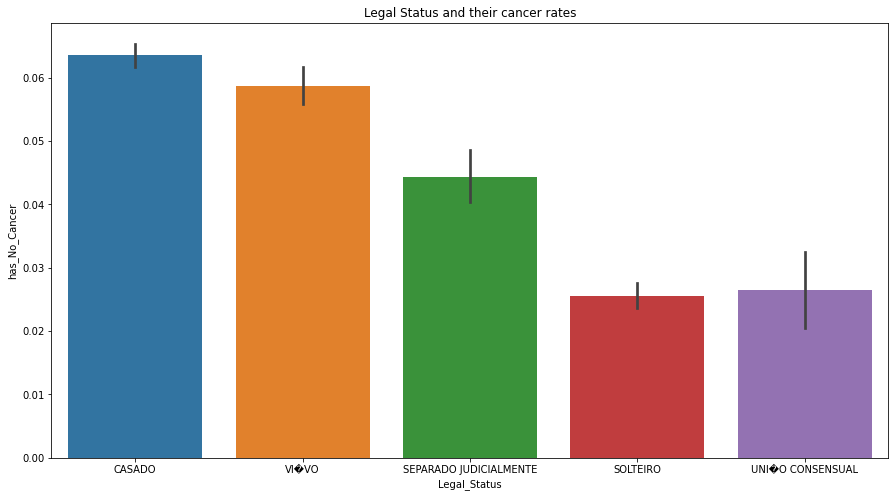

In [9]:
plt.figure(figsize=(15,8))
plt.title('Legal Status and their cancer rates')
sns.barplot(x = 'Legal_Status', y = 'has_No_Cancer', data = train)

### Lets take a closer look at the majority and see if it holds a significance using a chi squared test

<AxesSubplot:title={'center':'Casado and their cancer rates'}, xlabel='Legal_Status_Casado', ylabel='has_No_Cancer'>

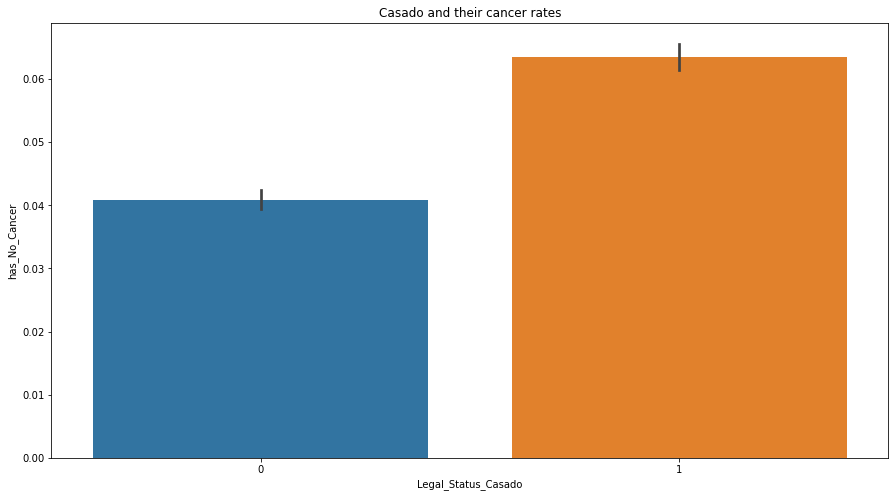

In [10]:
plt.figure(figsize=(15,8))
plt.title('Casado and their cancer rates')
sns.barplot(x = 'Legal_Status_Casado', y = 'has_No_Cancer', data = train)

In [11]:
observed = pd.crosstab(train['Legal_Status_Casado'], train.has_No_Cancer)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.12f}')

Observed
has_No_Cancer            0     1
Legal_Status_Casado             
0                    56738  2418
1                    57647  3910
--------------------------------------
---
Expected
[[56054.93244307  3101.06755693]
 [58330.06755693  3226.93244307]]
--------------------------------------
---

chi^2 = 310.9150
p     = 0.000000000000


## 2) The options inserted for race/color, do any of these options have more of a cause of no cancer?

<AxesSubplot:title={'center':'Race/Color and their cancer rates'}, xlabel='Race_Color', ylabel='has_No_Cancer'>

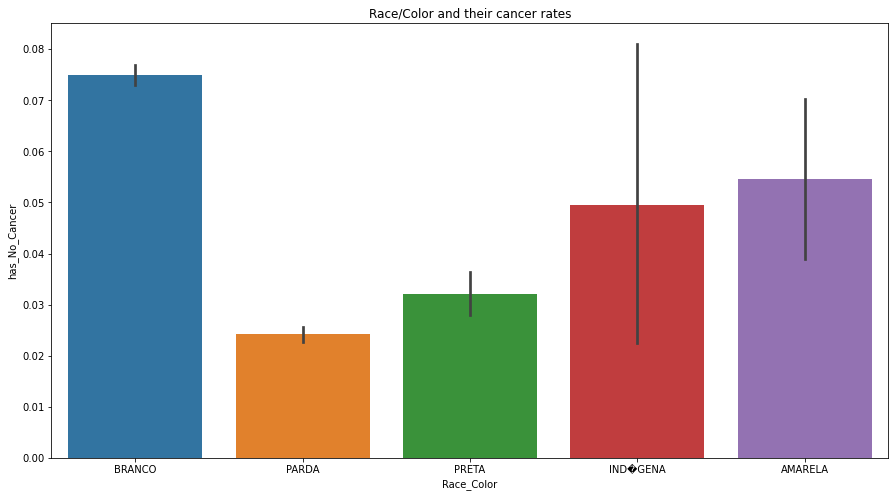

In [12]:
plt.figure(figsize=(15,8))
plt.title('Race/Color and their cancer rates')
sns.barplot(x = 'Race_Color', y = 'has_No_Cancer', data = train)

### Lets take a closer look at the majority and see if it holds a significance using a chi squared test

<AxesSubplot:title={'center':'Branco and their cancer rates'}, xlabel='Race_Color_BRANCO', ylabel='has_No_Cancer'>

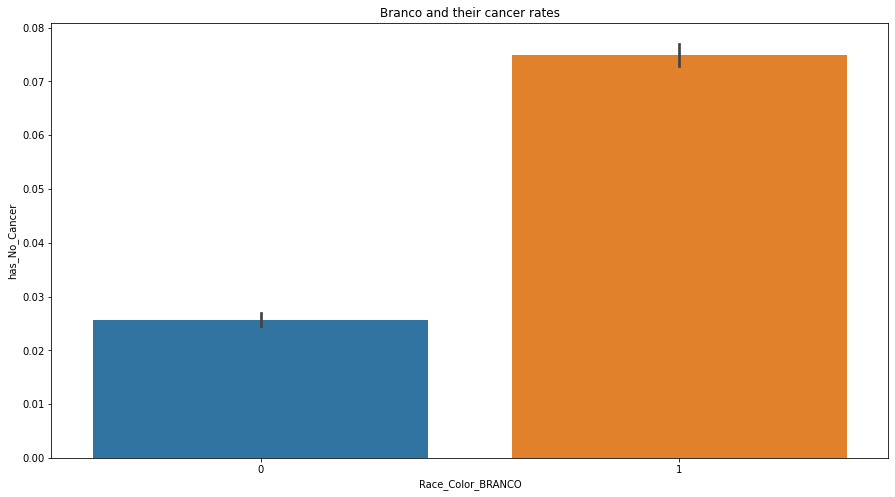

In [13]:
plt.figure(figsize=(15,8))
plt.title('Branco and their cancer rates')
sns.barplot(x = 'Race_Color_BRANCO', y = 'has_No_Cancer', data = train)

In [14]:
observed = pd.crosstab(train['Race_Color_BRANCO'], train.has_No_Cancer)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.12f}')

Observed
has_No_Cancer          0     1
Race_Color_BRANCO             
0                  53769  1417
1                  60616  4911
--------------------------------------
---
Expected
[[52293.04722772  2892.95277228]
 [62091.95277228  3435.04722772]]
--------------------------------------
---

chi^2 = 1462.9450
p     = 0.000000000000


##### Really low p-value so this does hold a signficance 

# 3)Does education background have an effect on no cancer patients and is there a signifcance in the majority?

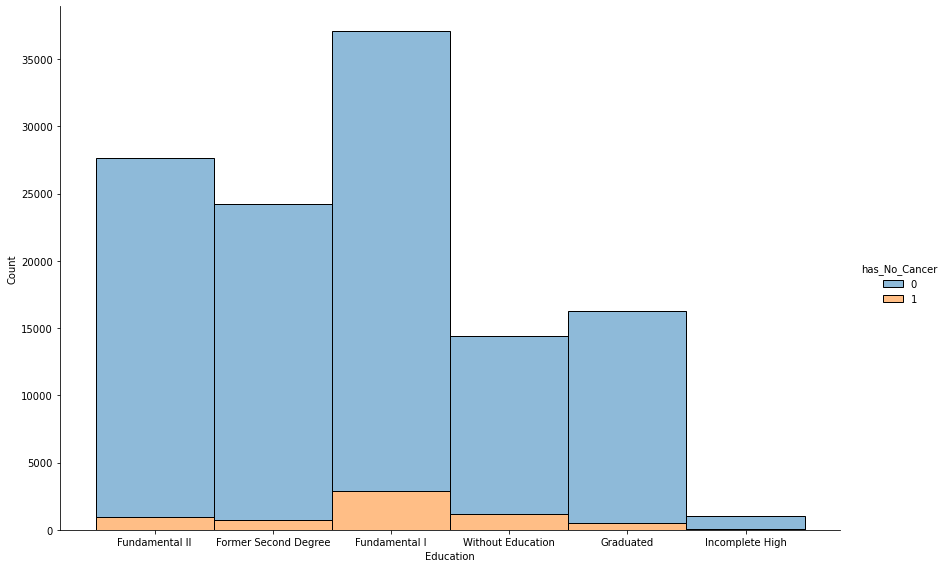

In [15]:
sns.displot(x = 'Education', data = train, hue = 'has_No_Cancer', alpha = 0.5, multiple = 'stack',
            height=8, aspect=12/8)

#### Lets take a closer look at Fundamental I using a chi squared test to see if it has a significance

<AxesSubplot:title={'center':'Education Fundamental I and their cancer rates'}, xlabel='Education_Fundamental I', ylabel='has_No_Cancer'>

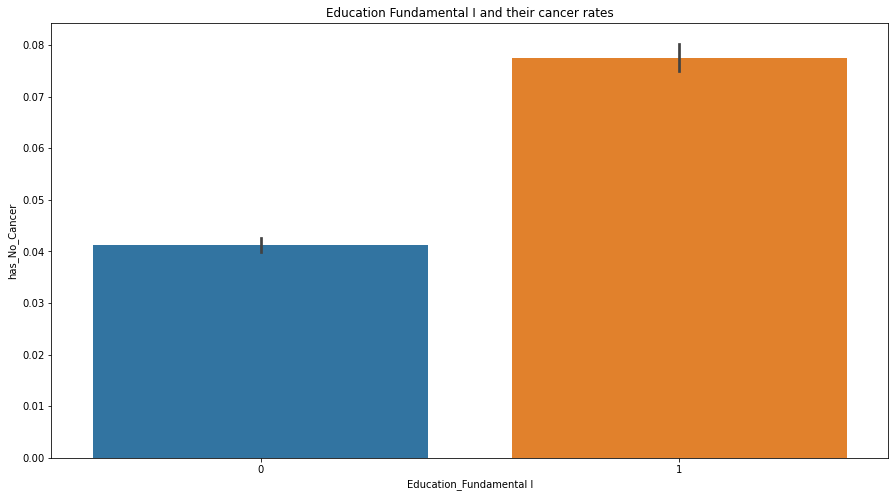

In [16]:
plt.figure(figsize=(15,8))
plt.title('Education Fundamental I and their cancer rates')
sns.barplot(x = 'Education_Fundamental I', y = 'has_No_Cancer', data = train)

In [17]:
observed = pd.crosstab(train['Education_Fundamental I'], train.has_No_Cancer)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.12f}')

Observed
has_No_Cancer                0     1
Education_Fundamental I             
0                        80196  3452
1                        34189  2876
--------------------------------------
---
Expected
[[79263.01624514  4384.98375486]
 [35121.98375486  1943.01624514]]
--------------------------------------
---

chi^2 = 681.5372
p     = 0.000000000000


##### Fundamental I does hold a low p-value indicating it has significance with no cancer patients

# 4) Is gender a factor of no cancer patients?

<AxesSubplot:title={'center':'Male or not and their cancer rates'}, xlabel='Gender_Male', ylabel='has_No_Cancer'>

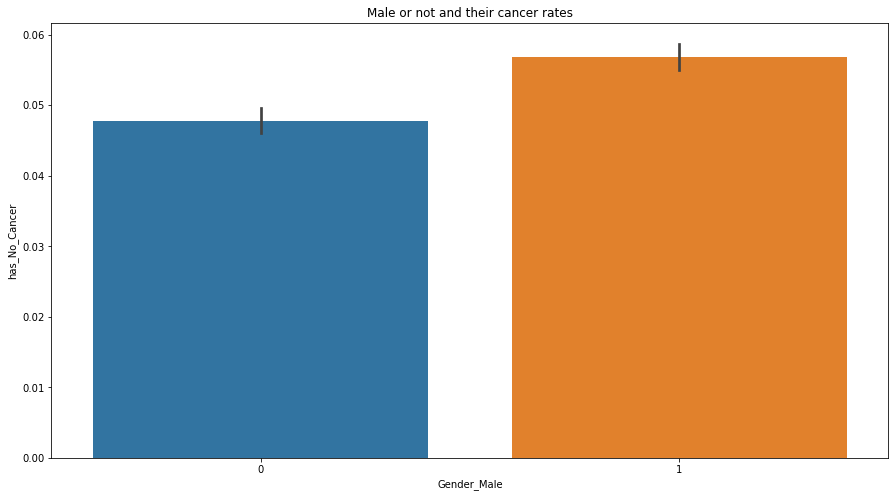

In [18]:
plt.figure(figsize=(15,8))
plt.title('Male or not and their cancer rates')
sns.barplot(x = 'Gender_Male', y = 'has_No_Cancer', data = train)

In [19]:
observed = pd.crosstab(train['Gender_Male'], train.has_No_Cancer)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.12f}')

Observed
has_No_Cancer      0     1
Gender_Male               
0              56010  2807
1              58375  3521
--------------------------------------
---
Expected
[[55733.70345365  3083.29654635]
 [58651.29654635  3244.70345365]]
--------------------------------------
---

chi^2 = 50.7737
p     = 0.000000000001


##### Using a chi squared test we see that male holds a significance with no cancer pateients!

# Create a baseline

In [5]:
train['baseline'] = 0

validate['baseline'] = 0

test['baseline'] = 0

#### I set '0' for those with cancner since most of the patients at these hopsitals do in fact have cancer being the majority

In [6]:
baseline_accuracy = (train.has_No_Cancer == train.baseline).mean()
print(f'baseline train accuracy: {baseline_accuracy:.2%}')

baseline_accuracy = (validate.has_No_Cancer == validate.baseline).mean()
print(f'baseline validate accuracy: {baseline_accuracy:.2%}')

baseline_accuracy = (test.has_No_Cancer == test.baseline).mean()
print(f'baseline test accuracy: {baseline_accuracy:.2%}')

baseline train accuracy: 94.76%
baseline validate accuracy: 94.76%
baseline test accuracy: 94.76%


In [7]:
X_train = train.drop(columns = ['has_No_Cancer', 'baseline', 'Gender', 'Age', 'Nationality',
                               'Education', 'Legal_Status', 'Status_Address', 'City_Address',
                               'Rare_Case', 'Diagnostic_means', 'Type_of_Death', 'year', 'Race_Color'])
y_train = train[['has_No_Cancer']]


X_validate = validate.drop(columns = ['has_No_Cancer', 'baseline', 'Gender', 'Age', 'Nationality',
                               'Education', 'Legal_Status', 'Status_Address', 'City_Address',
                               'Rare_Case', 'Diagnostic_means', 'Type_of_Death', 'year', 'Race_Color'])
y_validate = validate[['has_No_Cancer']]

X_test = test.drop(columns = ['has_No_Cancer', 'baseline', 'Gender', 'Age', 'Nationality',
                               'Education', 'Legal_Status', 'Status_Address', 'City_Address',
                               'Rare_Case', 'Diagnostic_means', 'Type_of_Death', 'year', 'Race_Color'])
y_test = test[['has_No_Cancer']]

# ---------------------------
# Modeling
# ---------------------------

#### Moving forward we will using our classification report to indicate our better model, so high f-scores is what I'll be looking for!
#### We're looking for positive predictions, so rather than having a precise or fewer recalls hence the smote method we want to have a balance between the two hence f1-score and just aim fo the highest score overall between the models!

## --------------------------------
## Random forest w/o SMOTE

In [13]:
ranf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state= 123)
ranf = ranf.fit(X_train, y_train)

In [14]:
y_pred = ranf.predict(X_train)

In [15]:
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    114385
           1       1.00      0.00      0.00      6328

    accuracy                           0.95    120713
   macro avg       0.97      0.50      0.49    120713
weighted avg       0.95      0.95      0.92    120713



##### I noticed this has no f-score at all for our no cancer patients, so lets see if this will working on a a different algorithm

## --------------------------------
## KNN W/O SMOTE

In [16]:
knn1 = KNeighborsClassifier()

knn1 = knn1.fit(X_train, y_train)

In [17]:
# Produce y_predictions that come from the X_validate
y_pred_knn = knn1.predict(X_train)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train, y_pred_knn))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97    114385
           1       0.00      0.00      0.00      6328

    accuracy                           0.95    120713
   macro avg       0.47      0.50      0.49    120713
weighted avg       0.90      0.95      0.92    120713



### We see a score f1-score but its really low? The issue being we're trying to classify Cancer and no cancer patients but our data set has a small number of no cancer patients, so moving forward we'll use SMOTE, since the data is skewed heavily for cancer patients lets raise the amount of no cancer patients and see if our model will have an overall better f1-score in detecting no cancer patients!

# SMOTE

In [28]:
### Data is skewed to favor for cancer so lets change the size and see if we get a different result
## Explain briefly 

In [18]:
sm = SMOTE(random_state=123)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

X_validate_res, y_validate_res = sm.fit_resample(X_validate, y_validate)

X_test_res, y_test_res = sm.fit_resample(X_test, y_test)

## -----------------------
## KNN w/ SMOTE

In [19]:
knn1 = KNeighborsClassifier()
knn1_res = knn1.fit(X_train_res, y_train_res)

In [20]:
# Produce y_predictions that come from the X_validate
y_pred_knn_res = knn1_res.predict(X_train_res)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train_res, y_pred_knn_res))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62    114385
           1       0.62      0.68      0.65    114385

    accuracy                           0.63    228770
   macro avg       0.64      0.63      0.63    228770
weighted avg       0.64      0.63      0.63    228770



#### Here we see big imporvment with SMOTE with a higher f1-score so lets test this on other algorithms

## ----------------------------
## Random forest w/ smote

In [21]:
ranf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state= 123)
ranf_res = ranf.fit(X_train_res, y_train_res)
y_pred_ranf_res = ranf.predict(X_train_res)

In [22]:
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train_res, y_pred_ranf_res))

              precision    recall  f1-score   support

           0       0.65      0.77      0.70    114385
           1       0.71      0.58      0.64    114385

    accuracy                           0.67    228770
   macro avg       0.68      0.67      0.67    228770
weighted avg       0.68      0.67      0.67    228770



## -----------------------------
## Decision Tree w/ SMOTE

In [23]:
clf = DecisionTreeClassifier(max_depth=3, random_state= 123)

clf = clf.fit(X_train_res, y_train_res)

y_pred_dec_res = clf.predict(X_train_res)

In [24]:
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_train_res, y_pred_dec_res))

              precision    recall  f1-score   support

           0       0.62      0.81      0.70    114385
           1       0.73      0.51      0.60    114385

    accuracy                           0.66    228770
   macro avg       0.68      0.66      0.65    228770
weighted avg       0.68      0.66      0.65    228770



## ---------------------------
# Validation W/ Smote
## ---------------------------

## Knn validate w/ smote

In [27]:

knn1_res_validate = knn1.fit(X_validate_res, y_validate_res)


# Produce y_predictions that come from the X_validate
y_pred_knn_validate = knn1_res_validate.predict(X_validate_res)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate_res, y_pred_knn_validate))

              precision    recall  f1-score   support

           0       0.65      0.58      0.61     49023
           1       0.62      0.69      0.65     49023

    accuracy                           0.63     98046
   macro avg       0.64      0.63      0.63     98046
weighted avg       0.64      0.63      0.63     98046



## Random forest validate w/ smote

In [25]:

ranf_validate = ranf.fit(X_validate_res, y_validate_res)
y_pred_ranf_validate = ranf_validate.predict(X_validate_res)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate_res, y_pred_ranf_validate))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67     49023
           1       0.67      0.70      0.69     49023

    accuracy                           0.68     98046
   macro avg       0.68      0.68      0.68     98046
weighted avg       0.68      0.68      0.68     98046



## Decision tree validation w/ smote

In [26]:

clf_validate = clf.fit(X_validate_res, y_validate_res)

y_pred_dec_validate = clf_validate.predict(X_validate_res)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate_res, y_pred_dec_validate))

              precision    recall  f1-score   support

           0       0.62      0.81      0.70     49023
           1       0.73      0.50      0.59     49023

    accuracy                           0.66     98046
   macro avg       0.67      0.66      0.65     98046
weighted avg       0.67      0.66      0.65     98046



### Randomf forest had a better f1-score for our target,so we'll use my Random forest for our final test!

## --------------------------------------------
# Test Random forest Test w/ smote
## --------------------------------------------

In [28]:
ranf_test = ranf.fit(X_test_res, y_test_res)
y_pred_ranf_test = ranf_test.predict(X_test_res)


# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_test_res, y_pred_ranf_test))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70     40852
           1       0.71      0.65      0.68     40852

    accuracy                           0.69     81704
   macro avg       0.69      0.69      0.69     81704
weighted avg       0.69      0.69      0.69     81704



## Key Takeaways

* Looking at gender, education, legal status, and race/color we see that they hold a high significance with no cancer patients based of chi squared tests and graphs. My random forest model despite the small sample size of no cancer patients, using SMOTE with a f1-score of 69% my model is able to detect positive predicitons of no cancer patients! Considering the same variables this could work the same for future unseen data!

## Recommendation

* First recommendation if possible is to recieve more data, since I had to remove many rows of informations, 1,700,000 down to 220,000 thousand since so much data is missing. We now know that the values I looked at hold a significance into patients wiht no cancer, further study is needed to see why these factors in Brazil is a possiblity and why being Male, Married (Casado), White (Blanco), and those in Fundamentals I have tendencies of no cancer than others!

## Next Steps

* Using near miss algorithm to do the oppisite of SMOTE and see if results would change for the better!
* Use more anomaly detection skills rather than classification and see the results
* Look at other factors of cancer and no cancer once more information such as looking at people at specific locations: cities, states, counties!
* Look at those who survived rather than cancer / no cacner and traget those who lived / died and see finding common attributes in those patients in Brazil!